# Maskinlæring

* Maskinlæring er i grunn bare komplisert statistikk/regresjon:
  * Vi tilpasser en modell så godt vi kan basert på tilgjengelig data
  * Modellen kan være en linje (lineær regresjon), eller valgtrær, support vector machines, nevrale netverk osv

## Eksempel med lineær regresjon

In [2]:
import json
import requests
from pyjstat import pyjstat
def hent_dataset(filnavn):
    with open(filnavn, 'r') as file:
        ssbAPIdata = json.load(file)

    postUrl = ssbAPIdata["postUrl"]
    tabellnummer = ssbAPIdata["tableIdForQuery"]
    query = ssbAPIdata["queryObj"]
    print(f"Henter data fra tabell {tabellnummer}")
    response = requests.post(postUrl, json=query)

    if response.status_code == 200:
        print("Data hentet: OK")
    else:
        print(f"""Data kunne ikke hentes, feilkode {response.status_code}
        Responstekst: response.text""")
        return None

    dataset = pyjstat.Dataset.read(response.text)
    df = dataset.write("dataframe")
    df_id = dataset.write("dataframe", naming="id")

    print(f"""Hentet dataset: {dataset['label']}""")
    return df, df_id, dataset

df, df_id, ds = hent_dataset("innenlandslanegjeld.json")
df_copy=df.copy()
df

Henter data fra tabell 06718
Data hentet: OK
Hentet dataset: 06718: Innenlandsk lånegjeld (mill. kr), etter låntakersektor, statistikkvariabel og måned


,låntakersektor,statistikkvariabel,måned,value
0,Husholdninger mv.,Innenlandsk lånegjeld,1987M12,448169
1,Husholdninger mv.,Innenlandsk lånegjeld,1988M01,450011
2,Husholdninger mv.,Innenlandsk lånegjeld,1988M02,453912
3,Husholdninger mv.,Innenlandsk lånegjeld,1988M03,456762
4,Husholdninger mv.,Innenlandsk lånegjeld,1988M04,458451
...,...,...,...,...
437,Husholdninger mv.,Innenlandsk lånegjeld,2024M05,4344594
438,Husholdninger mv.,Innenlandsk lånegjeld,2024M06,4363713
439,Husholdninger mv.,Innenlandsk lånegjeld,2024M07,4373839
440,Husholdninger mv.,Innenlandsk lånegjeld,2024M08,4394729


,Innenlandsk lånegjeld
måned,
1987-12-01,448169
1988-01-01,450011
1988-02-01,453912
1988-03-01,456762
1988-04-01,458451
...,...
2024-05-01,4344594
2024-06-01,4363713
2024-07-01,4373839


<Axes: xlabel='måned'>

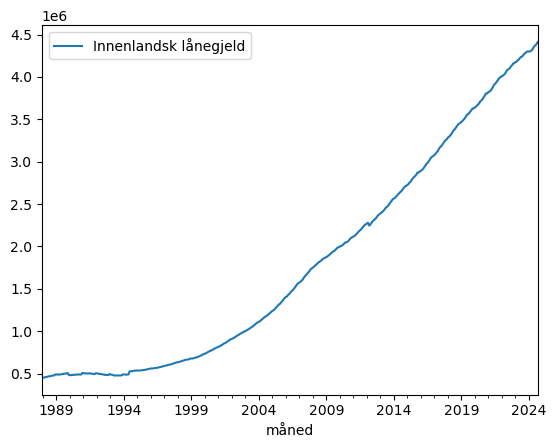

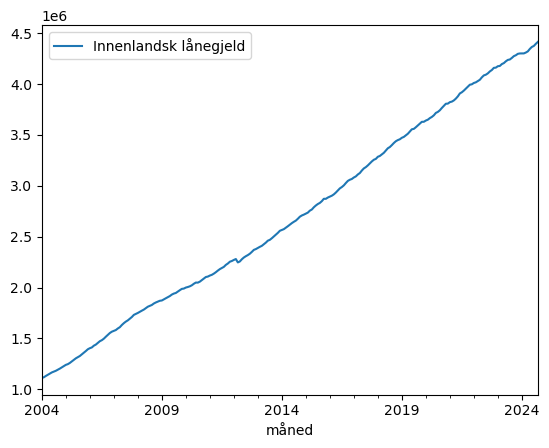

In [4]:
import pandas as pd

df = df_copy.copy()
df = df.drop(columns=["låntakersektor", "statistikkvariabel"])
df["måned"] = pd.to_datetime(df["måned"], format="%YM%m")
df = df.rename(columns={"value": "Innenlandsk lånegjeld"})
df=df.set_index("måned")
display(df)
df.plot()
##
df_linje = df.loc["2004":]
df_linje.plot()

,måned,Innenlandsk lånegjeld,dager
0,2004-01-01,1111599,0
1,2004-02-01,1118068,31
2,2004-03-01,1130944,60
3,2004-04-01,1142371,91
4,2004-05-01,1153443,121
...,...,...,...
244,2024-05-01,4344594,7426
245,2024-06-01,4363713,7457
246,2024-07-01,4373839,7487
247,2024-08-01,4394729,7518


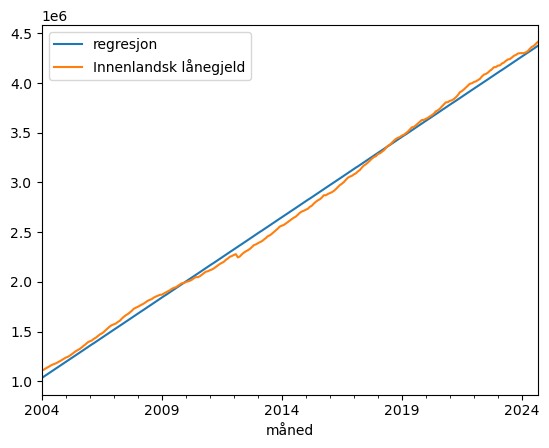

In [6]:
from sklearn.linear_model import LinearRegression

data = df_linje.reset_index()
data["dager"] = data["måned"] - data.loc[0,"måned"] #Ny kolonner med dager siden "start"

data["dager"] = data["dager"].dt.days # Fikser slik at dagene er flyttall
display(data)


X = data[["dager"]] #Velger uavhengige variabler (dager siden start)
y = data["Innenlandsk lånegjeld"] #Velger avhengig variabel (mål)

modell = LinearRegression() # Lager en lineær regresjonsmodell
resultat = modell.fit(X,y) #Tilpasser modell til data (læring)
data["regresjon"] = modell.predict(X) # Bruker modell til å anslå avhengig variabel
ax = data.plot(x="måned", y="regresjon")
data.plot(x="måned", y="Innenlandsk lånegjeld", ax=ax)

Rsquared = modell.score(X,y) #Score med hvor godt linjen "passer"

## Typer læring
* I hovedtrekk ofte to typer:
  * «Supervised learning»: Algoritmen eller modellen lærer fra input/output data (vi vet hva "resultatet" skal være)
  * «Unsupervised learning»: Algoritmen eller modellen finner mønstre i data vi ikke "kjenner" i utgangspunktet

## Hovedmål
* Målet med «læringen» er at den opplærte modellen vår skal «funke» på data vi ikke har sett før
* Dersom den gjør det sier vi at modellen generaliserer bra

Vi må da typisk unngå:
* «Overfitting»: Modellen memoriserer kun testdataen vår
* «Underfitting»: Modellen har ikke lært nok

![https://miro.medium.com/v2/resize:fit:720/format:webp/1*lARssDbZVTvk4S-Dk1g-eA.png](https://miro.medium.com/v2/resize:fit:720/format:webp/1*lARssDbZVTvk4S-Dk1g-eA.png)

# Testdata og treningsdata
* For å anslå om modellen vår er god, eller om vi overtilpasser den, holder vi gjerne tilbake forskjellige subset av dataene våres:
  * Vi kan feks trekkke ut tilfeldige 20% som ikke brukes til trening av modellen, men til å teste modellen etterpå
* Ellers justerer man på parametre i modellen, forenkler data, straffer kompleksitet og mange andre "triks" for å lage gode modeller

![https://www.researchgate.net/publication/357570421/figure/fig2/AS:11431281210648059@1702062985384/Training-and-validation-scheme-for-machine-learning-methods-The-database-is-split-and.tif](https://www.researchgate.net/publication/357570421/figure/fig2/AS:11431281210648059@1702062985384/Training-and-validation-scheme-for-machine-learning-methods-The-database-is-split-and.tif)

![https://i0.wp.com/thaddeus-segura.com/wp-content/uploads/2021/06/Screen-Shot-2021-06-17-at-7.03.33-PM-1.png?resize=532%2C658&ssl=1](https://i0.wp.com/thaddeus-segura.com/wp-content/uploads/2021/06/Screen-Shot-2021-06-17-at-7.03.33-PM-1.png?resize=532%2C658&ssl=1)

# Noen eksempler fra sklearn
* Klynger
* Support vector machines

In [8]:
import sklearn.cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


menn_bmi = 26.9
kvinner_bmi = 25.2

menn_h = 180.4
kvinner_h = 167.2

mm = menn_bmi*(menn_h/100)**2
mk = kvinner_bmi*(kvinner_h/100)**2

n = 1000

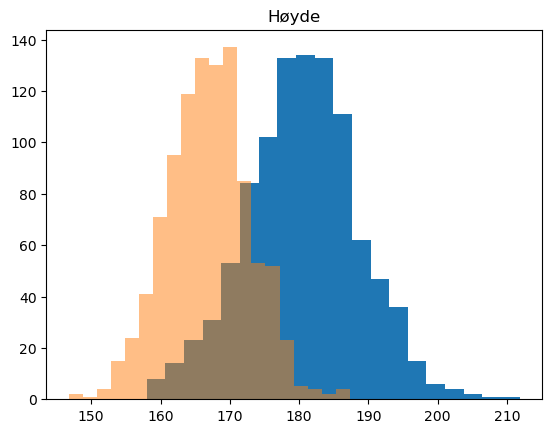

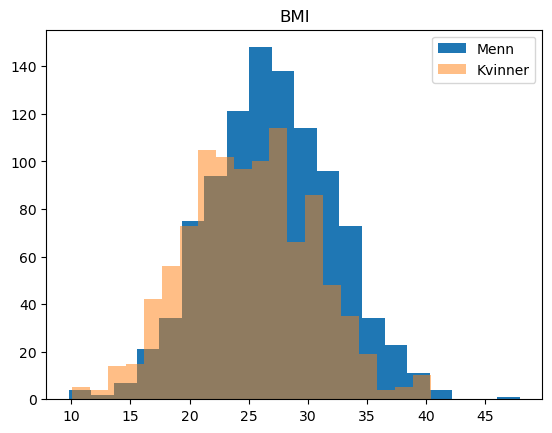

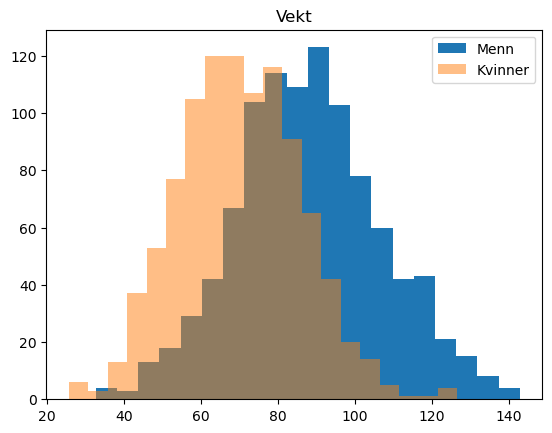

In [9]:
menn_bmi_liste = np.random.normal(loc=menn_bmi, scale=menn_bmi*0.2, size=n)
menn_hoyde_liste = np.random.normal(loc=menn_h, scale=8, size=1000)

kvinner_bmi_liste = np.random.normal(loc=kvinner_bmi, scale=menn_bmi*0.2, size=n)
kvinner_hoyde_liste = np.random.normal(loc=kvinner_h, scale=6, size=n)

menn_masse_liste = [ bmi*(h/100)**2 for bmi, h in zip(menn_bmi_liste, menn_hoyde_liste)]
kvinner_masse_liste = [ bmi*(h/100)**2 for bmi, h in zip(kvinner_bmi_liste, kvinner_hoyde_liste)]

plt.hist(menn_hoyde_liste, bins=20, label="Menn")
plt.hist(kvinner_hoyde_liste, bins=20, alpha=0.5, label="Kvinner")
plt.title("Høyde")
plt.show()


plt.hist(menn_bmi_liste, bins=20, label="Menn")
plt.hist(kvinner_bmi_liste, bins=20, alpha=0.5, label="Kvinner")
plt.legend()
plt.title("BMI")
plt.show()

plt.hist(menn_masse_liste, bins=20, label="Menn")
plt.hist(kvinner_masse_liste, bins=20, alpha=0.5, label="Kvinner")
plt.legend()
plt.title("Vekt")
plt.show()




,hoyde,vekt,Kjønn
1208,159.590083,57.473054,Kvinne
387,183.790352,87.257378,Mann
1394,173.827041,121.718900,Kvinne
974,186.876170,89.522366,Mann
668,173.639852,83.635781,Mann
...,...,...,...
1008,174.140801,46.013470,Kvinne
940,176.342483,59.937286,Mann
1568,174.172339,68.263378,Kvinne
159,176.764324,84.384250,Mann


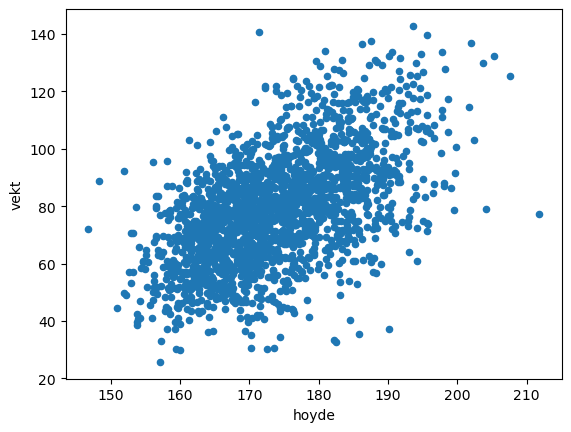

In [10]:
data={"hoyde": np.concatenate((menn_hoyde_liste, kvinner_hoyde_liste)), 
      "vekt":  np.concatenate((menn_masse_liste, kvinner_masse_liste)),
      "Kjønn": ["Mann"]*n+["Kvinne"]*n}


df = pd.DataFrame(data)
df.plot.scatter(x="hoyde", y="vekt")
df =df.reindex(np.random.permutation(df.index))
df

# KMeans clustering
* «Unsupervised learning»
* Vi prøver å dele data inn i klynger uten å nødvendigvis vite hva de representerer
* Noen ganger vet vi hvor mange klynger det burde være, andre ganger må vi prøve oss frem

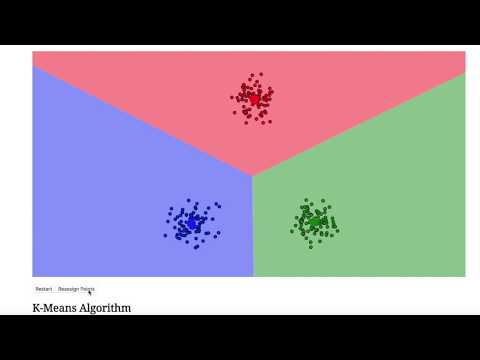

In [11]:
from IPython.display import YouTubeVideo
#Lenke: https://www.naftaliharris.com/blog/visualizing-k-means-clustering/
YouTubeVideo('R2e3Ls9H_fc', width=800, height=300)

In [15]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)
X = df[["hoyde", "vekt"]]
display(X)
result = model.fit(X)
df["cluster"] = model.predict(X)
df

,hoyde,vekt
1208,159.590083,57.473054
387,183.790352,87.257378
1394,173.827041,121.718900
974,186.876170,89.522366
668,173.639852,83.635781
...,...,...
1008,174.140801,46.013470
940,176.342483,59.937286
1568,174.172339,68.263378
159,176.764324,84.384250


C:\Programs\Anaconda3\2024.02\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Programs\Anaconda3\2024.02\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


,hoyde,vekt,Kjønn,cluster
1208,159.590083,57.473054,Kvinne,0
387,183.790352,87.257378,Mann,1
1394,173.827041,121.718900,Kvinne,1
974,186.876170,89.522366,Mann,1
668,173.639852,83.635781,Mann,1
...,...,...,...,...
1008,174.140801,46.013470,Kvinne,0
940,176.342483,59.937286,Mann,0
1568,174.172339,68.263378,Kvinne,0
159,176.764324,84.384250,Mann,1


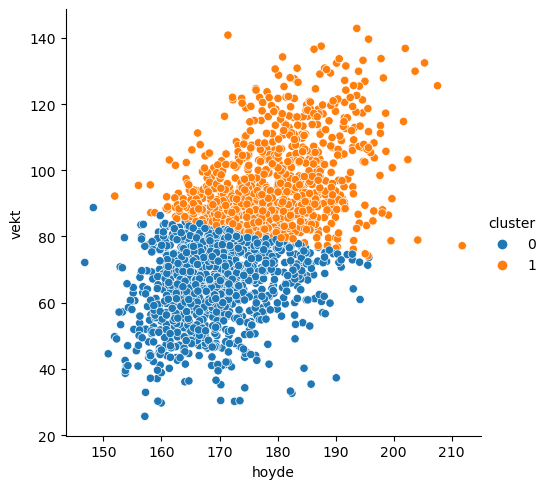

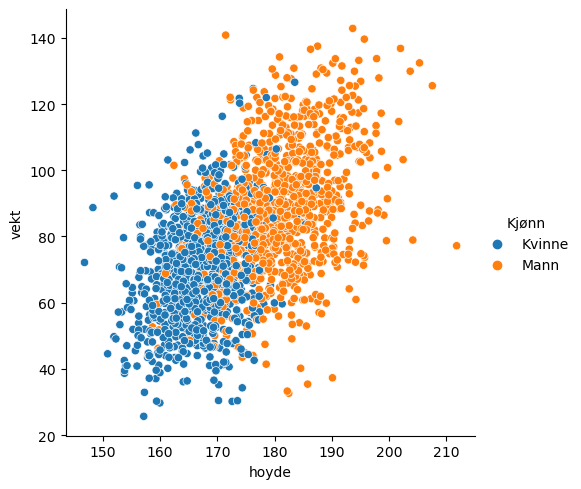

In [20]:
import seaborn as sns

sns.relplot(data=df, x="hoyde", y="vekt", hue="cluster")
sns.relplot(data=df, x="hoyde", y="vekt", hue="Kjønn")


# K-nearest neighbors
* «Supervised learning» - Vi har data hvor vi kjenner klassifiseringene
* For nye usette datapunkt undersøker vi de $k$ nærmeste naboene til datapunktet, og klassifiseringen deres
* Klassifiseringen til det nye datapunktet bestemmes av disse

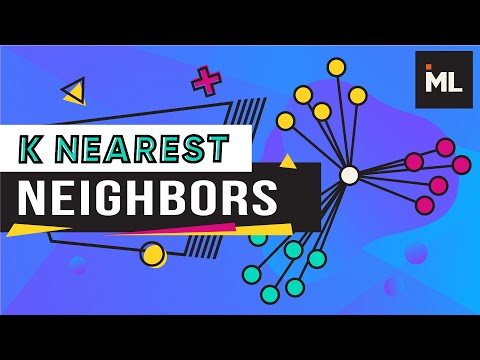

In [21]:
YouTubeVideo('0p0o5cmgLdE', width=800, height=300)

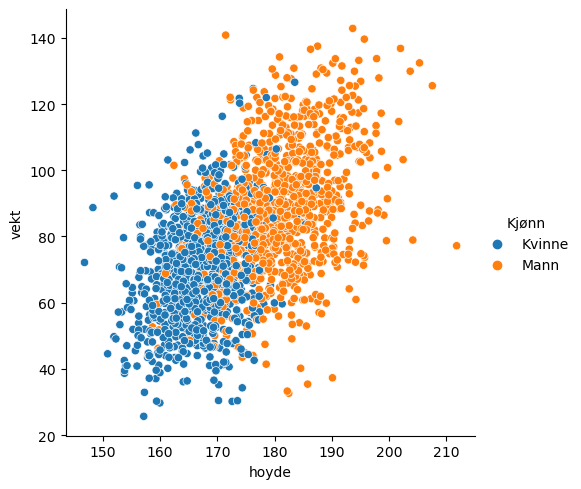

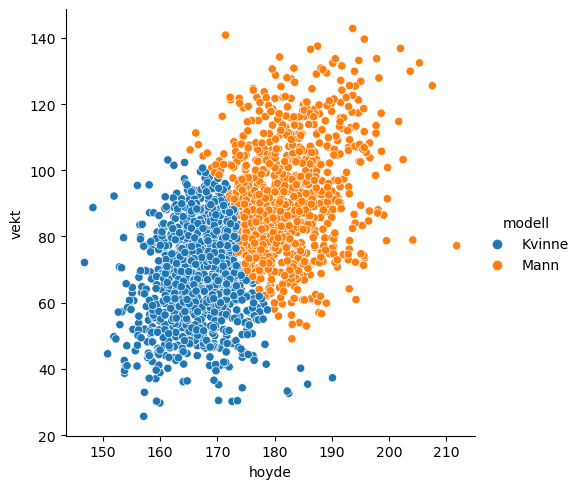

In [30]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=100)
X = df[["hoyde", "vekt"]] #Features
y = df["Kjønn"] #Target

resultat = model.fit(X,y)
df["modell"] = model.predict(X)

sns.relplot(data=df, x="hoyde", y="vekt", hue="Kjønn")
sns.relplot(data=df, x="hoyde", y="vekt", hue="modell")


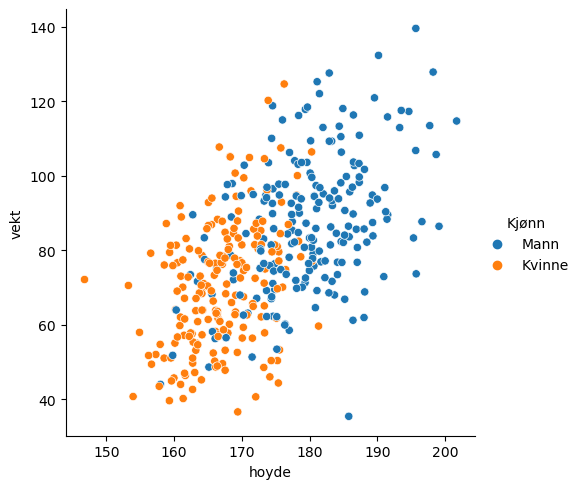

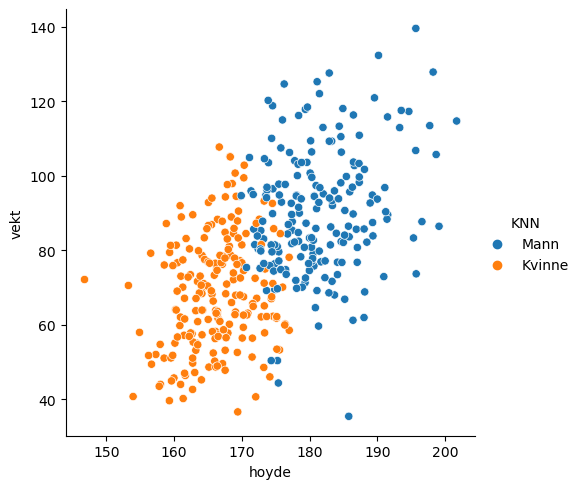

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = KNeighborsClassifier(n_neighbors=10)
X = df[["hoyde", "vekt"]] #Features
y = df["Kjønn"] #Target

resultat = model.fit(X_train,y_train)

df_test = pd.DataFrame(X_test)
df_test["KNN"] = model.predict(X_test)
df_test =  df_test.join(y_test)







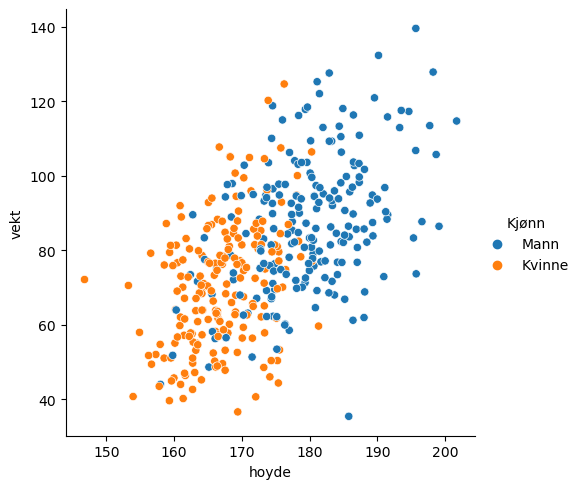

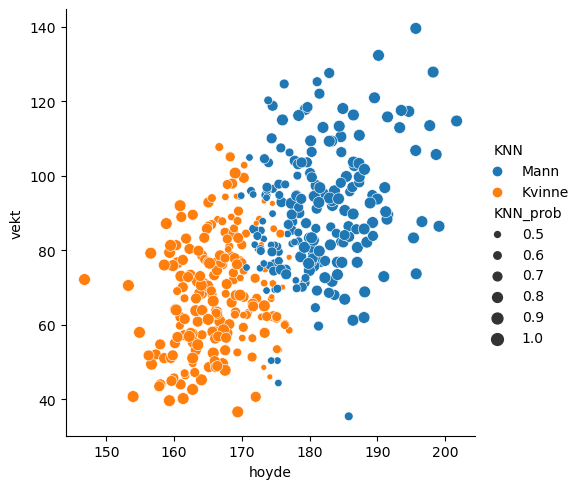

In [41]:

df_test["KNN_prob"] = list(map(max, model.predict_proba(X_test)))

sns.relplot(data=df_test, x="hoyde", y="vekt", hue="Kjønn")
sns.relplot(data=df_test, x="hoyde", y="vekt", hue="KNN", size="KNN_prob")

# Akademisk sukksess
[Dataset](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)

In [67]:
df = pd.read_csv("stud_dropout.csv")
df["Target"].unique()
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,15,1,1,1,1,1,6,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,15,1,1,19,1,1,10,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,12,1,1,1,22,27,10,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9,1,1,1,22,27,8,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


# Support vector machine
«supervised learning»

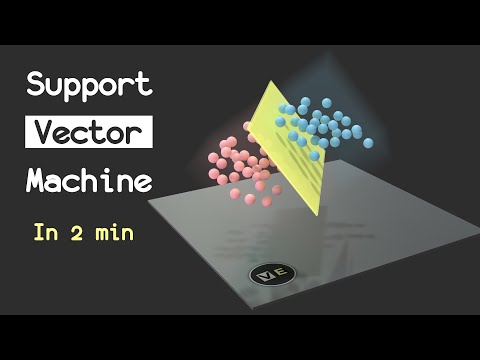

In [44]:
YouTubeVideo('_YPScrckx28', width=800, height=300)

In [65]:
from sklearn import svm

features = df.columns[~df.columns.str.contains("Target")]

X = df[features]
y = df["Target"]

clf = svm.SVC(probability=True, kernel='rbf')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

resultat = clf.fit(X_train, y_train)

probabilities = clf.predict_proba(X_test)



In [66]:
df_test = X_test
df_test = df_test.join(y_test)
df_test["modell"] = clf.predict(X_test)

res = df_test[["modell", "Target"]]

korrekt = res["modell"] == res["Target"]
suksessrate = sum(korrekt)/korrekt.size

print(f"Vi vil a rett ca {suksessrate:.2%} av gangene")

Vi vil a rett ca 74.24% av gangene
